In [1]:
%matplotlib inline
import torch
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
tcd = torch.distributions
torch.set_default_dtype(torch.float64) #without it we have underflow and we can encounter problems
sns.set_theme()

# Data

<AxesSubplot:>

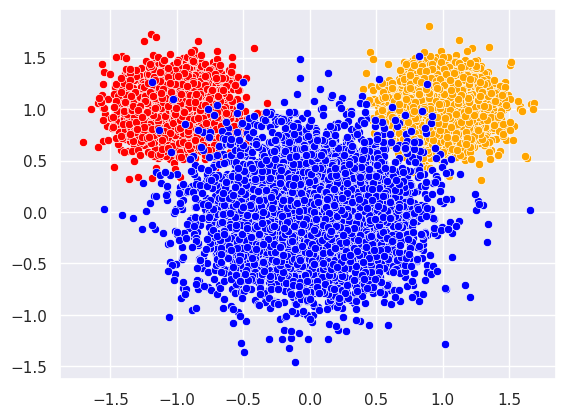

In [2]:
var_ear=0.2**2
var_head=0.4**2
left_ear = tcd.MultivariateNormal(torch.tensor([-1,1]).double(),var_ear*torch.eye(2))
right_ear = tcd.MultivariateNormal(torch.tensor([1,1]).double(),var_ear*torch.eye(2))
head= tcd.MultivariateNormal(torch.tensor([0,0]).double(),var_head*torch.eye(2))
N=10000
p=0.5
a = left_ear.sample(torch.Size([int(N*(1-p)/2)]))
b = right_ear.sample(torch.Size([int(N*(1-p)/2)]))
c = head.sample(torch.Size([int(N*p)]))
data = torch.cat((a, b, c))
sns.scatterplot(a[:,0],a[:,1],color="red")
sns.scatterplot(b[:,0],b[:,1],color="orange")
sns.scatterplot(c[:,0],c[:,1],color="blue")

# Initialization

In [3]:
def initialize(n):
    mu = torch.rand([n, 2]) * 4 - 2
    sigma = torch.rand([n, 2, 2])
    sigma = torch.matmul(sigma, torch.transpose(sigma, 1, 2))+torch.eye(2)*0.0001
    pi = torch.rand(n)
    pi = pi / torch.sum(pi)
    return sigma, mu, pi

# Expectation

In [4]:
def expectation_GMM(n,pi,mu,sigma,data):
    dis = []
    for i in range(n):
        dis.append(tcd.MultivariateNormal(loc=mu[i],covariance_matrix=sigma[i]))
    wyn = torch.zeros(len(data),n)
    for i in range(n):
        wyn[:,i]=dis[i].log_prob(data)
    wyn = torch.exp(wyn)
    for i in range(len(data)):
        wyn[i,:]=wyn[i,:]/torch.sum(wyn[i,:])
    return wyn

In [5]:
sigma, mu, pi = initialize(3)
print(pi)
print(mu)
print(sigma)

tensor([0.4617, 0.0614, 0.4769])
tensor([[-0.2719, -0.6207],
        [-0.2827,  0.3100],
        [ 0.4462,  1.8179]])
tensor([[[0.8387, 0.8864],
         [0.8864, 1.0357]],

        [[0.2068, 0.1664],
         [0.1664, 0.7520]],

        [[0.0646, 0.1237],
         [0.1237, 0.2380]]])


# Maximalization

In [6]:
def maximalization(likelihood, data,min_var=1e-3,eps=1e-3):
    suma=torch.sum(likelihood,axis=0)
    pi = suma/len(data)
    mu = (torch.matmul(data.T,likelihood) / suma).T
    sigma=(torch.einsum("ij,ia,ib->jab",likelihood,data,data)+torch.einsum("ij,ja,jb->jab",likelihood,mu,mu)+
    (torch.einsum("ij,ia,jb->jab",likelihood,-data,mu)+torch.einsum("ij,ja,ib->jab",likelihood,-mu,data)))
    for j in range(len(pi)):
        sigma[j]/=(suma[j]+eps)
    sigma=torch.clamp(sigma, min=min_var)
    return pi,mu,sigma

In [7]:
for u in range(1000):
    soft_reg=expectation_GMM(3,pi,mu,sigma,data)
    pi,mu,sigma=maximalization(soft_reg,data)

In [8]:
print(pi)
print(mu)
print(sigma)

tensor([0.2555, 0.2543, 0.4902])
tensor([[ 0.9957,  0.9975],
        [-0.9992,  0.9980],
        [-0.0041, -0.0286]])
tensor([[[0.0424, 0.0010],
         [0.0010, 0.0429]],

        [[0.0428, 0.0010],
         [0.0010, 0.0447]],

        [[0.1554, 0.0014],
         [0.0014, 0.1515]]])


# Clasification

In [9]:
def classy(wyn,data):
    ind=torch.argmax(wyn, axis=1)
    return ind

<AxesSubplot:>

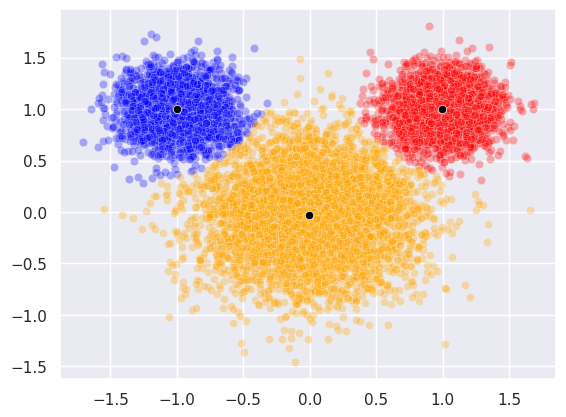

In [10]:
pred_EM=classy(soft_reg,data)
first=data[pred_EM==0]
sec=data[pred_EM==1]
third=data[pred_EM==2]
sns.scatterplot(first[:,0],first[:,1],color="red",alpha=0.3)
sns.scatterplot(sec[:,0],sec[:,1],color="blue",alpha=0.3)
sns.scatterplot(third[:,0],third[:,1],color="orange",alpha=0.3)
sns.scatterplot(mu[:,0],mu[:,1],color="black")

In [11]:
kmeans=KMeans(3,random_state=0).fit(data)

<AxesSubplot:>

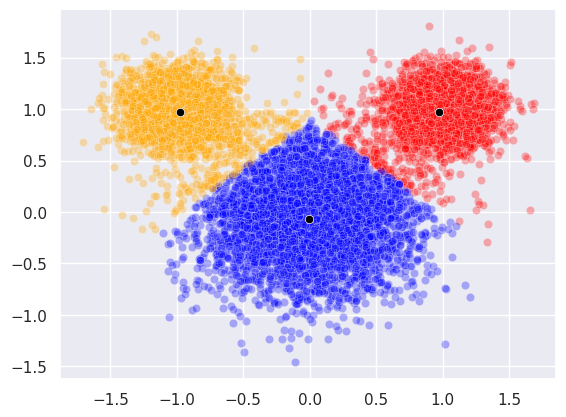

In [12]:
pred_KM=kmeans.predict(data)
first_KM=data[pred_KM==0]
sec_KM=data[pred_KM==1]
third_KM=data[pred_KM==2]
sns.scatterplot(first_KM[:,0],first_KM[:,1],color="red",alpha=0.3)
sns.scatterplot(sec_KM[:,0],sec_KM[:,1],color="blue",alpha=0.3)
sns.scatterplot(third_KM[:,0],third_KM[:,1],color="orange",alpha=0.3)
sns.scatterplot(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color="black")